<a href="https://colab.research.google.com/github/kevin-loaiza/senales_y_sistemas/blob/main/Pacial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Se tiene unmicroprocesador de 5 bits con entrada analoga de-3.3 a 5[v]. Diseñe el sistema de acondicionamiento y digitlizacion para la señal: x(t) = 20sin(7t-π/2)-3cos(5t)+2cos(10t). Presente las simulaciones y graficas de los procedimientos mas representativos en un cuaderno de Python, incluyendo al menos dos perıodos de la señal estudiada.

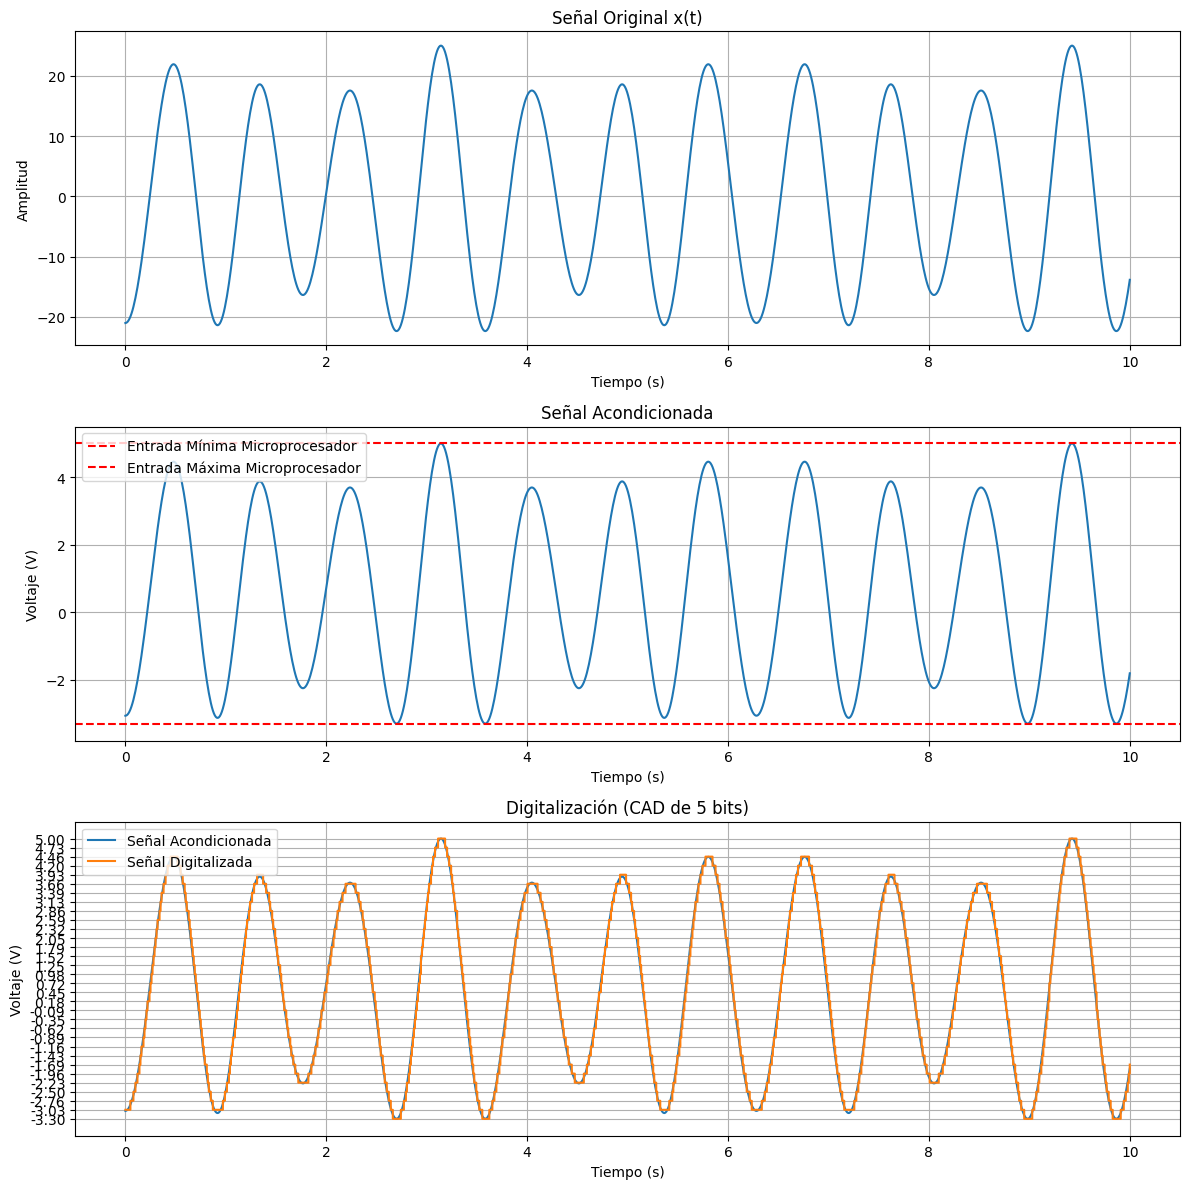

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define la señal x(t)
def signal_xt(t):
    return 20 * np.sin(7*t - np.pi/2) - 3 * np.cos(5*t) + 2 * np.cos(10*t)

# Genera el vector de tiempo (ajusta el rango y el número de puntos según sea necesario)
# Para obtener al menos dos períodos, necesitamos considerar las frecuencias (7, 5, 10).
# El período fundamental estará relacionado con el MCM de (2*pi/7, 2*pi/5, 2*pi/10).
# Para simplificar, elijamos un rango de tiempo que parezca razonable para la visualización.
t = np.linspace(0, 10, 1000) # Ejemplo de rango de tiempo y número de puntos

# Calcula la señal original
original_signal = signal_xt(t)

# --- Acondicionamiento de la Señal ---

# Determina el mínimo y el máximo de la señal original
min_original = np.min(original_signal)
max_original = np.max(original_signal)

# Rango de entrada del microprocesador
min_entrada = -3.3
max_entrada = 5.0

# Calcula el factor de escalado y el offset
# Mapea el rango [min_original, max_original] al rango [min_entrada, max_entrada]
# Factor de escalado: (max_entrada - min_entrada) / (max_original - min_original)
# Offset: min_entrada - factor_escalado * min_entrada

scaling_factor = (max_entrada - min_entrada) / (max_original - min_original)
offset = min_entrada - scaling_factor * min_original

conditioned_signal = scaling_factor * original_signal + offset

# --- Digitalización (CAD de 5 bits) ---

#numero de bits
bits= 5
cant_niveles = 2**bits


# Tamaño del paso para cada nivel en el rango de entrada
step_size = (max_entrada - min_entrada) / (cant_niveles - 1)

# Niveles de cuantización
quantizacion_niveles = np.linspace(min_entrada, max_entrada, cant_niveles)

# Proceso de digitalización
digitized_signal = np.zeros_like(conditioned_signal)
for i, value in enumerate(conditioned_signal):
    # Encuentra el nivel de cuantización más cercano
    closest_level_index = np.argmin(np.abs(quantizacion_niveles - value))
    digitized_signal[i] = quantizacion_niveles[closest_level_index]

# --- Graficar ---

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(t, original_signal)
plt.title('Señal Original x(t)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, conditioned_signal)
plt.title('Señal Acondicionada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje (V)')
plt.ylim(min_entrada - 0.5, max_entrada + 0.5) # Mostrar el rango de entrada
plt.axhline(min_entrada, color='r', linestyle='--', label='Entrada Mínima Microprocesador')
plt.axhline(max_entrada, color='r', linestyle='--', label='Entrada Máxima Microprocesador')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, conditioned_signal, label='Señal Acondicionada')
plt.step(t, digitized_signal, where='post', label='Señal Digitalizada')
plt.title('Digitalización (CAD de 5 bits)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje (V)')
plt.ylim(min_entrada - 0.5, max_entrada + 0.5) # Mostrar el rango de entrada
plt.yticks(quantizacion_niveles, [f'{level:.2f}' for level in quantizacion_niveles]) # Mostrar niveles de cuantización en el eje Y
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

2. Cual es la señal obtenida en tiempo discreto al utilizar un conversor analogo digital con frecuencia de muestreo de 5kHz, aplicado a la señal x(t) = 3cos(1000πt) + 5sin(2000πt) + 10cos(11000πt)?. Realizar la simulacion del proceso de discretizacion. En caso de que la discretizacion no sea apropiada, diseñe e implemente un conversor adecuado para la señal estudiada.

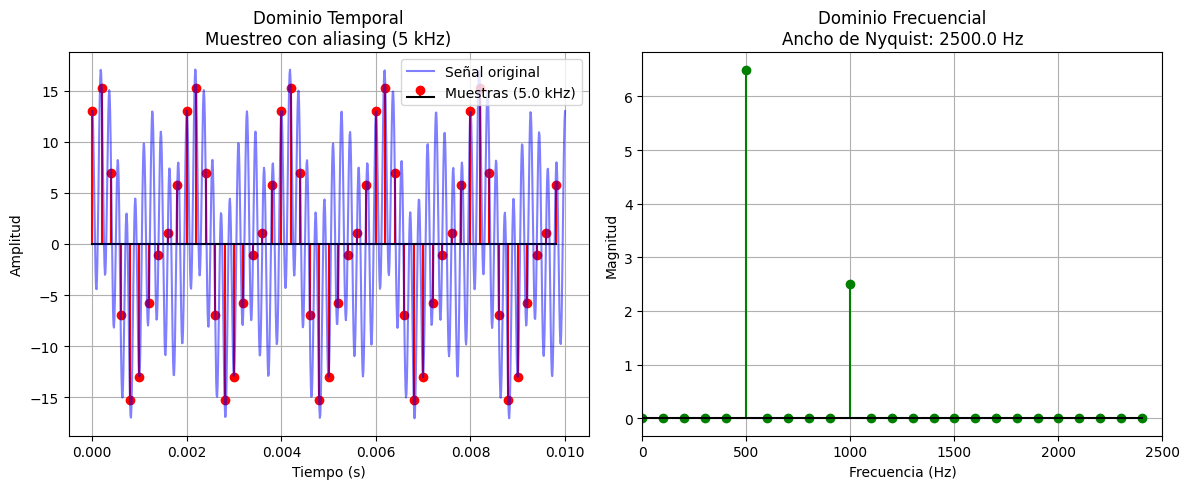

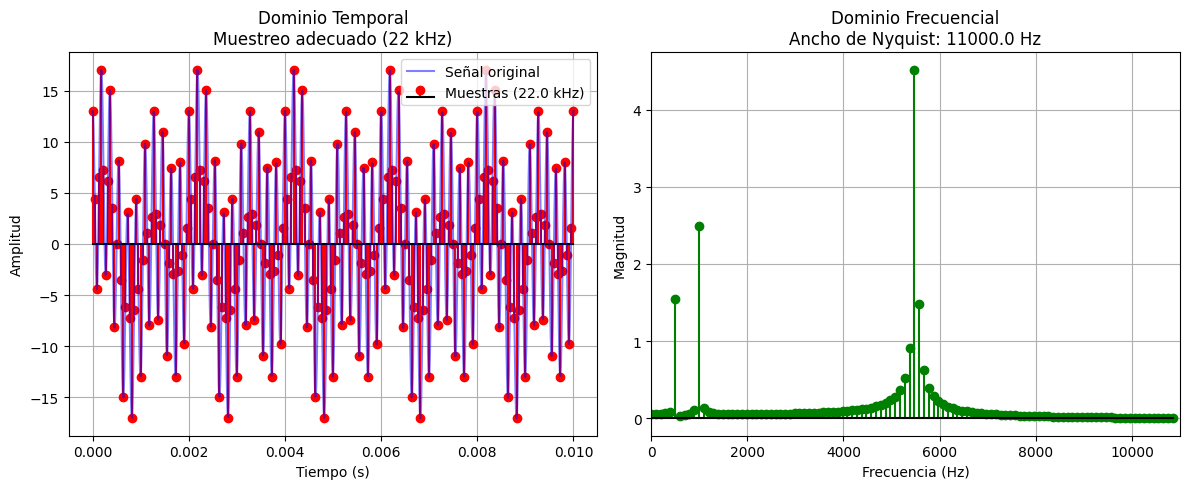

In [11]:
# Importación de librerías
import numpy as np  # Para operaciones numéricas y manejo de arrays
import matplotlib.pyplot as plt  # Para creación de gráficos
from scipy.fft import fft, fftfreq  # Para la Transformada Rápida de Fourier (FFT)

# Configuración de parámetros de la señal

# Frecuencias de los componentes sinusoidales (en Hz)
f1 = 500   # Frecuencia baja 1
f2 = 1000  # Frecuencia baja 2
f3 = 5500  # Frecuencia alta (provocará aliasing con fs baja)

# Amplitudes de cada componente de la señal
amplitudes = [3, 5, 10]  # [A1, A2, A3]

# Frecuencias de muestreo (sampling rates)
fs_insuficiente = 5000   # 5 kHz (insuficiente para f3)
fs_adecuada = 22000      # 22 kHz (suficiente para todas las frecuencias)

# Duración de la señal en segundos
duration = 0.01          # 10 milisegundos


# Función para analizar el efecto del muestreo
def analizar_muestreo(fs, title):
    # Generación del vector de tiempo discreto
    # np.arange(inicio, fin, paso) crea puntos equidistantes desde 0 hasta duration
    # con intervalos de 1/fs segundos
    t = np.arange(0, duration, 1/fs)

    # Creación de la señal muestreada compuesta por 3 sinusoides
    x = (amplitudes[0] * np.cos(2*np.pi*f1*t) +  # Componente de 500 Hz
         amplitudes[1] * np.sin(2*np.pi*f2*t) +   # Componente de 1000 Hz
         amplitudes[2] * np.cos(2*np.pi*f3*t))    # Componente de 5500 Hz

    # Cálculo de la Transformada Rápida de Fourier (FFT)
    N = len(t)  # Número de muestras

    # fftfreq calcula las frecuencias asociadas a cada bin de la FFT
    # Argumentos:
    #   N: número de puntos
    #   1/fs: intervalo de muestreo (en segundos)
    # [:N//2] toma solo la mitad del espectro (frecuencias positivas)
    freq = fftfreq(N, 1/fs)[:N//2]

    # Cálculo de la FFT:
    # 1. fft(x) calcula la transformada (devuelve valores complejos)
    # 2. [:N//2] toma solo la mitad del espectro
    # 3. np.abs() calcula la magnitud (elimina la fase)
    # 4. /N normaliza la amplitud
    X = np.abs(fft(x)[:N//2]) / N

    # Generación de la señal continua de referencia para comparación
    t_cont = np.linspace(0, duration, 1000)  # 1000 puntos para una curva suave
    x_cont = (amplitudes[0] * np.cos(2*np.pi*f1*t_cont) +
              amplitudes[1] * np.sin(2*np.pi*f2*t_cont) +
              amplitudes[2] * np.cos(2*np.pi*f3*t_cont))


    # Creación de gráficos
    plt.figure(figsize=(12, 5))  # Figura de 12x5 pulgadas

    # Subgráfico 1: Dominio del tiempo
    plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, posición 1

    # Gráfico de tallos para mostrar las muestras discretas
    plt.stem(t, x, 'r',          # Color rojo
             markerfmt='ro',      # Marcadores rojos
             basefmt="black",     # Línea base negra
             linefmt='r-',        # Líneas rojas
             label=f'Muestras ({fs/1000} kHz)')  # Leyenda

    # Gráfico de línea para la señal original continua
    plt.plot(t_cont, x_cont, 'b-', alpha=0.5, label='Señal original')
    plt.title(f'Dominio Temporal\n{title}')  # Título
    plt.xlabel('Tiempo (s)')      # Etiqueta eje X
    plt.ylabel('Amplitud')        # Etiqueta eje Y
    plt.legend()                  # Muestra la leyenda
    plt.grid(True)                # Activa la cuadrícula

    # Subgráfico 2: Dominio de la frecuencia
    plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, posición 2

    # Gráfico de tallos para el espectro de frecuencias
    plt.stem(freq, X, 'g',        # Color verde
             markerfmt='go',       # Marcadores verdes
             basefmt="black")      # Línea base negra

    plt.title(f'Dominio Frecuencial\nAncho de Nyquist: {fs/2} Hz')
    plt.xlabel('Frecuencia (Hz)')  # Etiqueta eje X
    plt.ylabel('Magnitud')         # Etiqueta eje Y
    plt.xlim(0, fs/2)             # Limita el eje X a la frecuencia de Nyquist
    plt.grid(True)                # Activa la cuadrícula

    plt.tight_layout()  # Ajusta el espaciado entre subgráficos
    plt.show()         # Muestra la figura

# Análisis con frecuencia insuficiente (5 kHz)
analizar_muestreo(fs_insuficiente, "Muestreo con aliasing (5 kHz)")

# Análisis con frecuencia adecuada (12 kHz)
analizar_muestreo(fs_adecuada, "Muestreo adecuado (22 kHz)")


3.La distancia media entre dos senales $ x1(t), x2(t) ∈ R, C$, se
puede expresar a partir de la potencia media:

$d(x_1, x_2) = \overline{P}_{x_1 - x_2} = \lim_{T \to \infty} \frac{1}{T} \int_{0}^{T} |x_1(t) - x_2(t)|^2 dt.$

Sean $x1(t)$ y $x2(t)$:

$x_1(t) = A \cos(\omega_0 t), \quad \omega_0 = \frac{2\pi}{T}, \quad T, A \in \mathbb{R}^+$


$x_2(t)$ = \begin{cases}
1 & \text{si } 0 \leq t < \frac{T}{4} \\
-1 & \text{si } \frac{T}{4} \leq t < \frac{3T}{4} \\
1 & \text{si } \frac{3T}{4} \leq t < T
\end{cases}

¿Cual es la distancia media entre las señales?. Corrobore sus
desarrollos con Sympy.

Potencia media de la diferencia: A**2/2 - 4*A/pi + 1
Distancia media: sqrt(A**2/2 - 4*A/pi + 1)
Distancia media entre x1(t) y x2(t): 0.4638


<ipython-input-13-cca62bd5dfba>:55: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  potencia_media = np.trapz(diff_squared, t_vals) / T  # Integral sobre el periodo / T


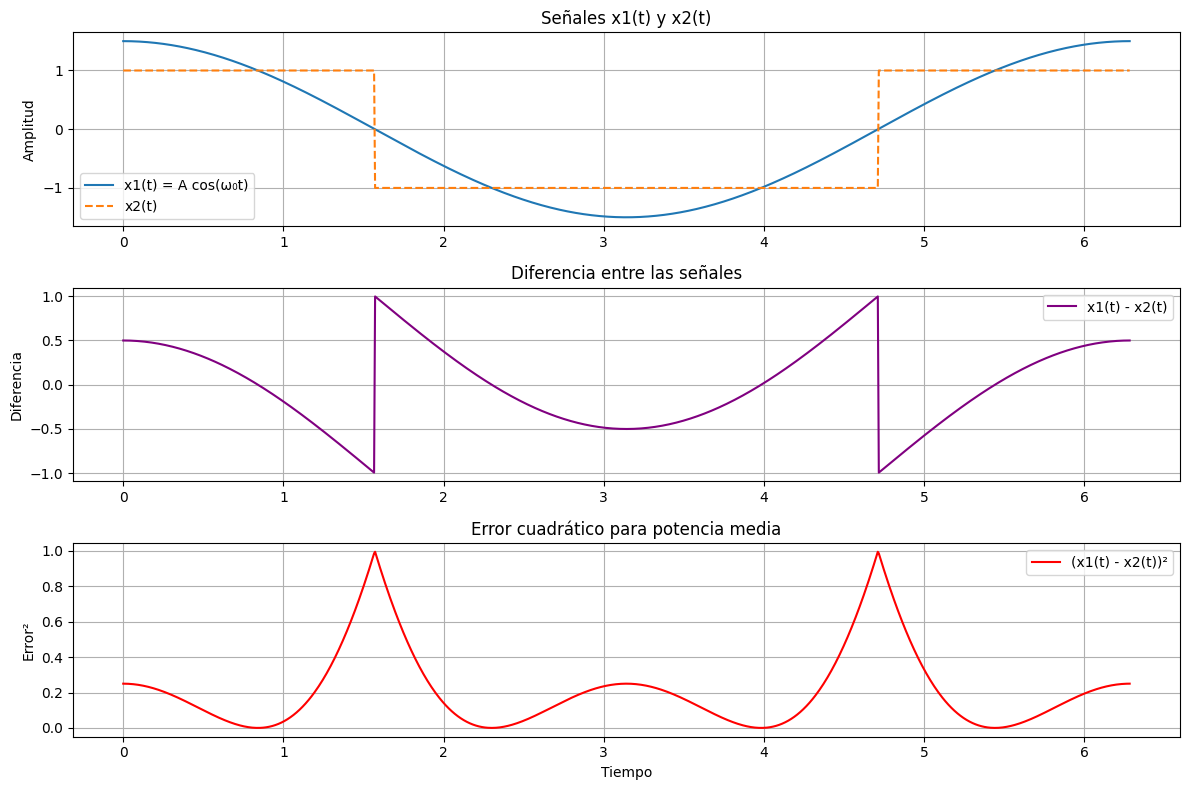

In [13]:
#Demostracion numerica
import sympy as sp

# Definir variables
t, T, A = sp.symbols('t T A', real=True, positive=True)
omega0 = 2 * sp.pi / T

# Definir las señales
x1 = A * sp.cos(omega0 * t)
x2 = sp.Piecewise(
    (1, (t >= 0) & (t < T/4)),
    (-1, (t >= T/4) & (t < 3*T/4)),
    (1, (t >= 3*T/4) & (t < T))
)

# Diferencia al cuadrado
diff_squared = (x1 - x2)**2

# Potencia media de la diferencia
P_avg = (1/T) * sp.integrate(diff_squared, (t, 0, T))

# Simplificar
P_avg_simplified = sp.simplify(P_avg)
d = sp.sqrt(P_avg_simplified)

print(f"Potencia media de la diferencia: {P_avg_simplified}")
print(f"Distancia media: {d}")
#-------------------------------------------------------------------------------

#Demostracion grafica

import numpy as np
import matplotlib.pyplot as plt

# Parámetros
A = 1.5  # Amplitud de x1
T = 2 * np.pi  # Periodo de ambas señales
omega0 = 2 * np.pi / T  # Frecuencia angular

# Vector de tiempo: un periodo completo
t_vals = np.linspace(0, T, 1000)

# Señal x1(t) = A * cos(omega0 * t)
x1 = A * np.cos(omega0 * t_vals)

# Señal x2(t) definida por tramos
x2 = np.piecewise(
    t_vals,
    [t_vals < T/4, (t_vals >= T/4) & (t_vals < 3*T/4), t_vals >= 3*T/4],
    [1, -1, 1]
)

# Diferencia y su cuadrado
diff = x1 - x2
diff_squared = diff**2

# Cálculo de la distancia media
potencia_media = np.trapz(diff_squared, t_vals) / T  # Integral sobre el periodo / T
distancia_media = np.sqrt(potencia_media)

# Mostrar la distancia media
print(f"Distancia media entre x1(t) y x2(t): {distancia_media:.4f}")

# Gráficas
plt.figure(figsize=(12, 8))

# Señales
plt.subplot(3, 1, 1)
plt.plot(t_vals, x1, label='x1(t) = A cos(ω₀t)')
plt.plot(t_vals, x2, '--', label='x2(t)')
plt.title("Señales x1(t) y x2(t)")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()

# Diferencia
plt.subplot(3, 1, 2)
plt.plot(t_vals, diff, color='purple', label='x1(t) - x2(t)')
plt.title("Diferencia entre las señales")
plt.ylabel("Diferencia")
plt.grid(True)
plt.legend()

# Diferencia al cuadrado
plt.subplot(3, 1, 3)
plt.plot(t_vals, diff_squared, color='red', label='(x1(t) - x2(t))²')
plt.title("Error cuadrático para potencia media")
plt.xlabel("Tiempo")
plt.ylabel("Error²")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()